Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


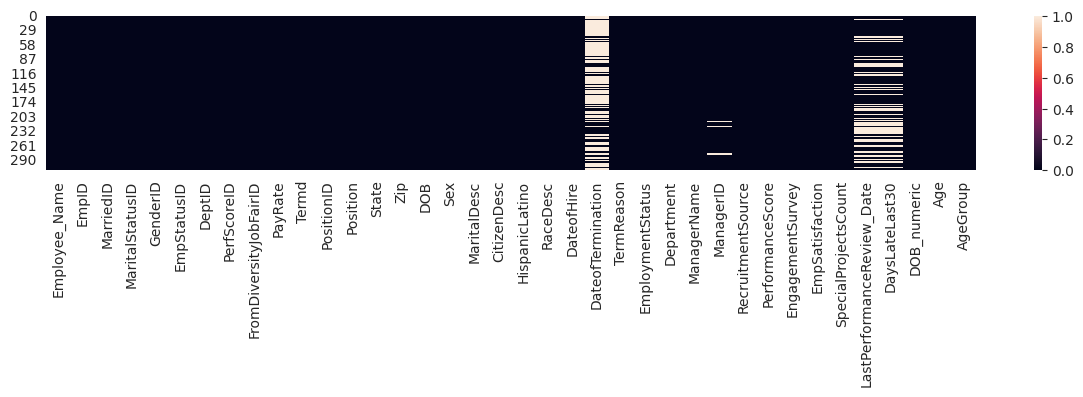

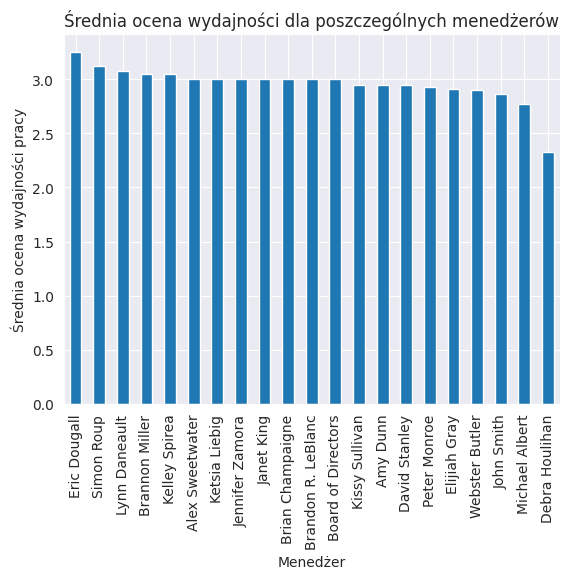

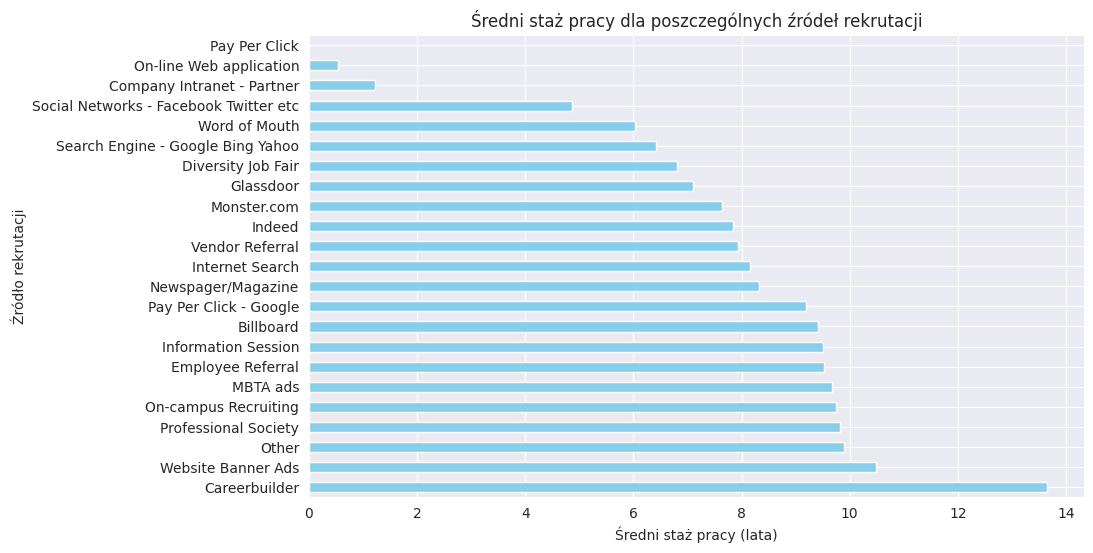

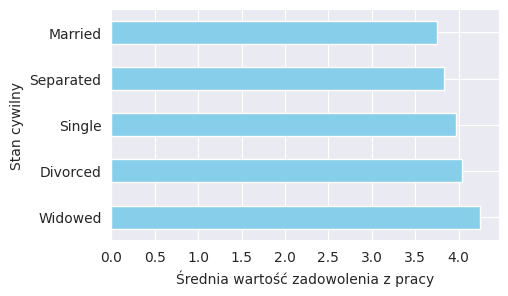

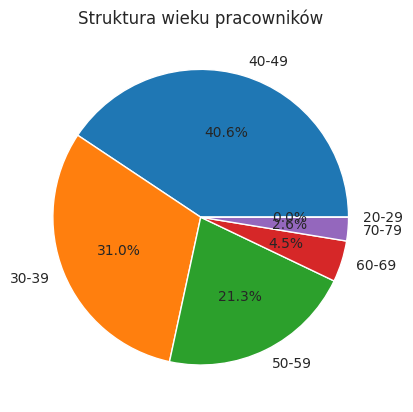

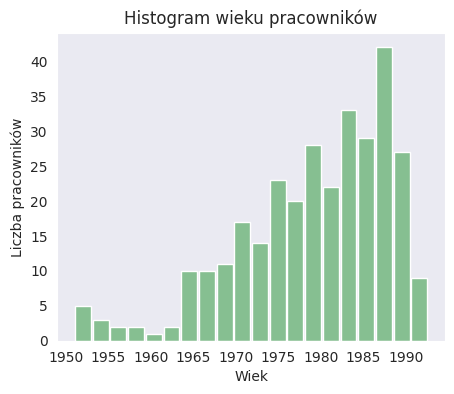

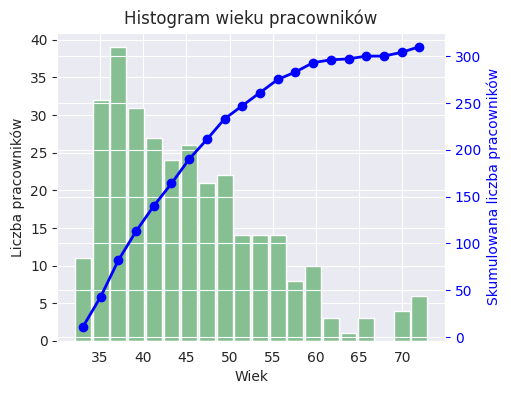

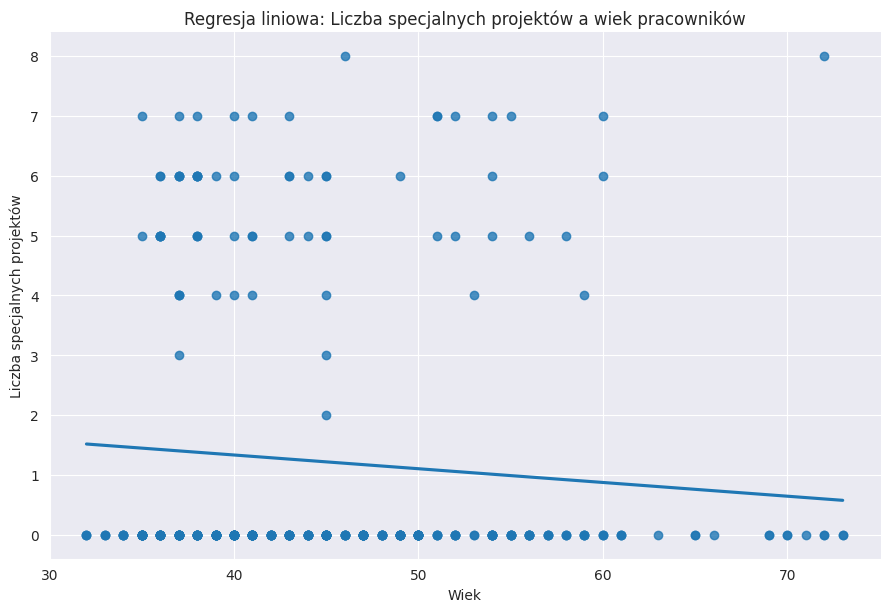

<ipython-input-117-225feaf7ee77>:124: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_group_projects = df.groupby('AgeGroup')['SpecialProjectsCount'].mean()


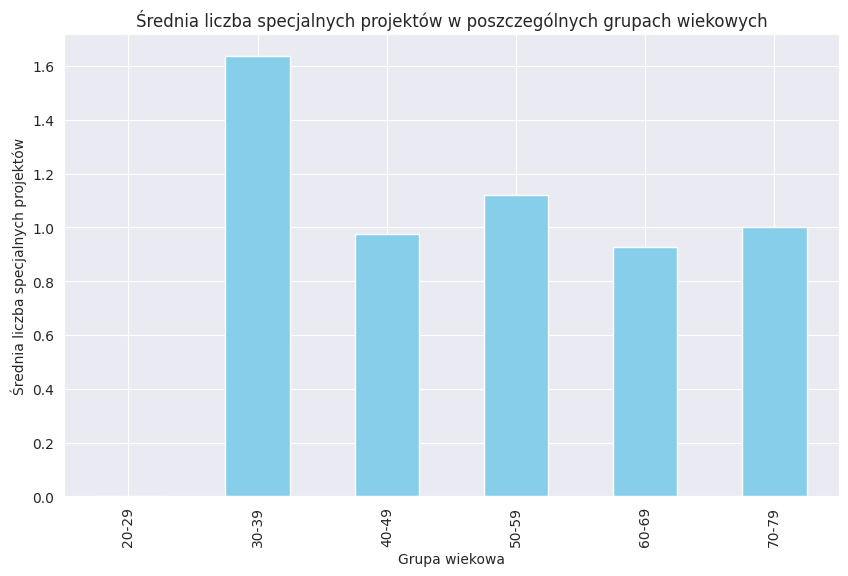

In [ ]:
from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import numpy as np

# Pobranie plików
drive.mount('/content/drive')
data_path = '/content/drive/My Drive/Colab Notebooks/AnalizaDanych/HRDataset.csv'
df = pd.read_csv(data_path)

# Ranki dla poszczególnych ocen poziomu wydajności
performance_map = {
    'Needs Improvement': 1,
    'PIP': 2,
    'Fully Meets': 3,
    'Exceeds': 4
}

# Konwersja kolumn na typ datetime
def convert_dob(dob):
  date = pd.to_datetime(dob, format='%m/%d/%y', errors='coerce')
  if date.year > pd.to_datetime('today').year: date = date.replace(year=date.year - 100)
  return date

df['DOB_numeric'] = df['DOB'].apply(convert_dob)
df['DateofTermination'] = pd.to_datetime(df['DateofTermination'],format='%m/%d/%y')
df['DateofHire'] = pd.to_datetime(df['DateofHire'],format='%m/%d/%Y')

# Grupy wiekowe
df['Age'] = df['DOB_numeric'].apply(lambda x: current_date.year - x.year - ((current_date.month, current_date.day) < (x.month,x.day)))
age_bins = [20, 30, 40, 50, 60, 70, 80]
age_labels = ['20-29', '30-39', '40-49', '50-59', '60-69', '70-79']
df['AgeGroup'] = pd.cut(df['Age'], bins=age_bins, labels=age_labels, right=False)

# Sprawdzenie kompletności danych
df.dropna(thresh=2,inplace=True)
plt.figure(figsize=(15,2))
sns.heatmap(df.isnull())
plt.show()

# Analiza zależności między przełożonym a wydajnością pracy jego zespołu
df['PerformanceScoreRank'] = df['PerformanceScore'].map(performance_map)
manager_performance = df.groupby('ManagerName')['PerformanceScoreRank'].mean().sort_values(ascending=False).round(2)
manager_performance.plot(kind='bar', title='Średnia ocena wydajności pracy dla poszczególnych menedżerów')
plt.title('Średnia ocena wydajności dla poszczególnych menedżerów')
plt.xlabel('Menedżer')
plt.ylabel('Średnia ocena wydajności pracy')
plt.show()

# Analiza zależności między stażem a źródłem rekrutacji
df['JobSeniority'] = df['DateofHire'] - df['DateofTermination']
df['JobSeniority'] = df['JobSeniority'].dt.days

df['DateofHire'] = pd.to_datetime(df['DateofHire'])
df['DateofTermination'] = pd.to_datetime(df['DateofTermination'])
current_date = pd.to_datetime('now')

df['JobSeniority'] = df.apply(lambda row: (row['DateofTermination'] if pd.notna(row['DateofTermination']) else current_date) - row['DateofHire'], axis=1)
df['JobSeniority'] = df['JobSeniority'].dt.days / 365.25

recruitment_best_sources = df.groupby('RecruitmentSource')['JobSeniority'].mean().sort_values(ascending=False)
plt.figure(figsize=(10, 6))
recruitment_best_sources.plot(kind='barh', color='skyblue')
plt.xlabel('Średni staż pracy (lata)')
plt.ylabel('Źródło rekrutacji')
plt.title('Średni staż pracy dla poszczególnych źródeł rekrutacji')
plt.show()

# Analiza zależności między stanem cywilnym pracownika a zadowoleniem z pracy
martiality_satisfaction = df.groupby('MaritalDesc')['EmpSatisfaction'].mean().sort_values(ascending=False)
plt.figure(figsize=(5, 3))
martiality_satisfaction.plot(kind='barh', color='skyblue')
plt.xlabel('Średnia wartość zadowolenia z pracy')
plt.ylabel('Stan cywilny')
plt.show()

# Struktura wieku pracowników
plt.pie(df['AgeGroup'].value_counts(), labels=df['AgeGroup'].value_counts().index, autopct='%1.1f%%')
plt.title('Struktura wieku pracowników')
plt.show()

df.hist(column='DOB_numeric', bins=20, grid=False, figsize=(5,4), color='#86bf91', zorder=2, rwidth=0.9)
plt.title('Histogram wieku pracowników')
plt.xlabel('Wiek')
plt.ylabel('Liczba pracowników')
plt.show()

fig, ax1 = plt.subplots(figsize=(5, 4))
ax1.hist(df['Age'], bins=20, color='#86bf91', zorder=2, rwidth=0.9)
ax1.set_title('Histogram wieku pracowników')
ax1.set_xlabel('Wiek')
ax1.set_ylabel('Liczba pracowników')

age_counts, bin_edges = np.histogram(df['Age'], bins=20)
cum_counts = np.cumsum(age_counts)
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])

ax2 = ax1.twinx()
ax2.plot(bin_centers, cum_counts, color='blue', marker='o', linewidth=2)
ax2.set_ylabel('Skumulowana liczba pracowników')
ax2.yaxis.label.set_color('blue')
ax2.tick_params(axis='y', colors='blue')
plt.show()

sns.lmplot(x='Age', y='SpecialProjectsCount', data=df, height=6, aspect=1.5, ci=None)
plt.title('Regresja liniowa: Liczba specjalnych projektów a wiek pracowników')
plt.xlabel('Wiek')
plt.ylabel('Liczba specjalnych projektów')
plt.show()

# Analiza liczby specjalnych projektów dla  poszczególnych grup wiekowych
age_group_projects = df.groupby('AgeGroup')['SpecialProjectsCount'].mean()
plt.figure(figsize=(10, 6))
age_group_projects.plot(kind='bar', color='skyblue')
plt.xlabel('Grupa wiekowa')
plt.ylabel('Średnia liczba specjalnych projektów')
plt.title('Średnia liczba specjalnych projektów w poszczególnych grupach wiekowych')
plt.show()

# **Wnioski z danych:**
1. **Bezpośredni przełożony a wydajność pracy**
    - Istnieją różnice w wydajności pracy zależnie od bezpośredniego przełożonego
    - Najwyższą wydajność ma zespół Erica Dougalla
    - Najniższą wydajność ma zespół Debry Houlihan
    - Różnice między pozostałymi zespołami są  niewielkie
    
2. **Żródła pozyskiwania pracownika a staż pracy**
    - Zdedydowanie najlepszym źródłem pozyskwiania pracowników jest Careerbuilder. Osoby pochodzące z tego źródła mają średni staż na poziomie ponad 13 lat.
    - Drugim źródłem jest WebsiteCareer. Staż pracowników z tego źródła wynosi nieco ponad 10 lat.
    - Zdecydowanie najmniej wartościowymi źródłami są on-line Web application i Company Intranet - Partner. Staż pracowników rekrutowanych z tych źródeł nie przekracza roku.
3. **Stan cywilny a zadowolenie z pracy**
    - Najbardziej zadowoloni z pracy są wdowcy i rozwiedzeni
    - Najmniej zadowoleni są żonaci/zamężni

4. **Struktura wieku pracowników**
    - Najlicznieszą grupę stanowią pracownicy w wieku 40-49 lat (40,6%)
    - Drugą najlicznieszą grupę stanowią pracownicy w wieku 30-39 lat (31%)
5. **Wiek a liczba projektów specjalnych**
    - Nie ma silnej zależności między wiekiem pracowników a liczbą realizowanych przez nich projektów specjalnych
    - Na tle innych wyróżnia się jedynie grupa pracowników w wieku 30-39 lata którzą moją średnio 1,6 projektów, podczas gdy pracownicy z innych grup mają średnio jeden projekt specjalny.


